# Example using pellet dispenser

This notebook contains an example of how to run the code for using the multimaterial dispenser. Most cells can be run without any modification if the dispenser has been built without design modifications. The lines that need modifications are marked like this:

`###############################################################################`

In [1]:
# Import Libraries
import serial
import numpy as np
import time
import serial.tools.list_ports
import os
import sys
sys.path.append('../src/Python/')
from DispenserSetup import SetupDispenser, Compositions

In this cell, we define the port name for the arduino and the balance. We do it by listing the connected ports and selecting the ones whose device serial is the corresponding to our device. You should find the serial of your devices and change it accordingly. You can do it by inspecting the devices detected by serial.tools.list_ports.comports(). In case of doubt, try disconnecting and connecting to see which ports are affected.

In [2]:
ports = serial.tools.list_ports.comports()

###############################################################################

arduino_serial = '85036313530351F0B141'#"write_here_your_arduino_serial"
balance_serial = 'FT2OHLM4'#"write_here_your_balance_serial"

###############################################################################

for port in ports:
    if port.serial_number == arduino_serial:
        arduino_port = port.device
    elif port.serial_number == balance_serial:
        balance_port = port.device
        
### Serial initialization
## Arduino
arduino = serial.Serial(arduino_port, 9600)
## Balance
balance = serial.Serial(port=balance_port, baudrate=9600, bytesize=serial.SEVENBITS,
                       parity=serial.PARITY_EVEN, stopbits=serial.STOPBITS_ONE)

In the next cell, we use the Arduino Command Line Interface (arduino-cli) to compile and upload the arduino script. If you prefer to do it using the Graphical User Interface, skip this cell. For using it, update the location of your arduino-cli

In [3]:
###############################################################################################################

os.system("/home/miguel/Downloads/arduino-cli_0.33.0_Linux_64bit/arduino-cli compile --fqbn arduino:avr:mega ../src/Arduino/8noIRnew_NOshaketimer_new/8noIRnew_NOshaketimer_new.ino")
os.system("/home/miguel/Downloads/arduino-cli_0.33.0_Linux_64bit/arduino-cli upload -p "+arduino_port+" --fqbn arduino:avr:mega ../src/Arduino/8noIRnew_NOshaketimer_new/8noIRnew_NOshaketimer_new.ino")

#os.system("PATH/arduino-cli_0.33.0_Linux_64bit/arduino-cli compile --fqbn arduino:avr:mega ../src/Arduino/8noIRnew_NOshaketimer_new/8noIRnew_NOshaketimer_new.ino")
#os.system("PATH/arduino-cli upload -p "+arduino_port+" --fqbn arduino:avr:mega 8noIRnew_NOshaketimer_new/8noIRnew_NOshaketimer_new.ino")


###############################################################################################################

Sketch uses 9474 bytes (3%) of program storage space. Maximum is 253952 bytes.
Global variables use 788 bytes (9%) of dynamic memory, leaving 7404 bytes for local variables. Maximum is 8192 bytes.

Used library Version Path                                       
AccelStepper 1.64    /home/miguel/Arduino/libraries/AccelStepper

Used platform Version Path                                                       
arduino:avr   1.8.6   /home/miguel/.arduino15/packages/arduino/hardware/avr/1.8.6


0

The next step is to define the materials and their concentrations in each of the dispensers. For that we will use the `SetupDispenser` function from `/src/DispenserSetup`. It will require a `.csv` file detailing the compositions, that can be built following the example available in the help of the function:

In [4]:
help(SetupDispenser)

Help on function SetupDispenser in module DispenserSetup:

SetupDispenser(dispenser_setup_file, Polymer)
    Funtion to read the setup file and create structures to define what material each dispenser has.
    
    Inputs:
    
        dispenser_setup_file: full route of a .csv file with the different materials and how they are arranged. Example:
            Dispenser, PLA, GNP, CLO, BN
            1, 0.0, 0.0, 0.0, 0.0 # Empty
            2, 0.0, 0.0, 0.0, 0.0 # Empty
            3, 0.0, 0.0, 0.0, 0.0 # Empty
            4, 1.0, 0.0, 0.0, 0.0 # Contains pure polymer
            5, 0.9, 0.1, 0.0, 0.0 # Polymer with 10% GNP
            6, 0.9, 0.0, 0.0, 0.1 # Polymer with 10% BN
            7, 0.0, 0.0, 0.0, 0.0 # Empty
            8, 0.0, 0.0, 0.0, 0.0 # Empty
            
            Notes:
            - Only one polymer matrix allowed.
            - All of the non-empty dispensers must contain the polymer matrix and at most one additive.
            - The composition for each dispens

In [5]:
###############################################################################
D, M, A = SetupDispenser("../data/dispenser_setup.csv", "PLA")
###############################################################################

Dispenser 1: 100.0% of PLA, 
Dispenser 2: 90.0% of PLA, 10.0% of GNP, 
Dispenser 3: 90.0% of PLA, 10.0% of CLO, 


Next, we read the file that contains the compositions using the Compositions function. It's working is detailed in the documentation:

In [6]:
help(Compositions)

Help on function Compositions in module DispenserSetup:

Compositions(compositions_file, dispensers_map, M, A, Polymer)
    Funtion to read the compositions file and define what compositions to dispense.
    
    Inputs:
    
        compositions_file: full route of a .csv file with the ddesired compositions. Example:
            Composition,PLA,GNP,CLO,BN
            1,0.95,0.02,0.0,0.03
            2,0.95,0.04,0.0,0.01
            
        dispensers_map, M, A: arrays returned from SetupDispenser function. 
        
    Outputs:
        
        C: list of arrays with the quantities to dispense from each dispenser for every composition in the file.



In [7]:
###############################################################################
compositions = Compositions("../data/compositions_to_dispense.csv", D, M, A, "PLA")
###############################################################################
print(compositions)

Composition  0 : Concentrations add up.
Composition  1 : Concentrations add up.
[array([0.5, 0.2, 0.3, 0. , 0. , 0. , 0. , 0. ]), array([0.5, 0.4, 0.1, 0. , 0. , 0. , 0. , 0. ])]


For the rest of the notebook we will use only the first of the compositions available in the .csv file. in your application you can easily loop over all of them, just remember to change the cup in the balance between compositions.

In [8]:
C = compositions[0]

It is convenient now to establish a ratio between materials: in this way, instead of dispensing all the ammount of one material and then of another, we can alternate small quantities and thus have a better mixing. We do this by selecting the one with lower ammount and expressing the others as a ratio with respect to this one. In every step we will dispense 1 g of the smaller one and the corresponding grams of the rest.

In [9]:
tol = 1e-3
minC = np.min([c for c in C if c>tol])
ratios = C/minC 
print('The ratios for pellet dispensing will be: ', ratios)

The ratios for pellet dispensing will be:  [2.5 1.  1.5 0.  0.  0.  0.  0. ]


The next cell stablish commands to tare, calibrate and measure weight from the balance. You may need to edit them if your balance uses a different protocol.

In [10]:
###############################################################################
def tare(balance):
    # Set the balance measurement to 0.0 g
    try:
        balance.write(b'T\r\n')
    except:
        balance = serial.Serial(port=balance_port, baudrate=9600, bytesize=serial.SEVENBITS,
                       parity=serial.PARITY_EVEN, stopbits=serial.STOPBITS_ONE)
        balance.write(b'T\r\n')


def calib(balance):
    # Calibrate the balance automatically
    try:
        balance.write(b'C\r\n')
    except:
        balance = serial.Serial(port=balance_port, baudrate=9600, bytesize=serial.SEVENBITS,
                       parity=serial.PARITY_EVEN, stopbits=serial.STOPBITS_ONE)
        balance.write(b'C\r\n')

def measure(balance):
    try:
        trash = balance.read_all()
        balance.write(b'B\r\n')
        reading = balance.readline()
        weight = float(reading[:10])
    except:
        balance = serial.Serial(port=balance_port, baudrate=9600, bytesize=serial.SEVENBITS,
                       parity=serial.PARITY_EVEN, stopbits=serial.STOPBITS_ONE)
        trash = balance.read_all()
        balance.write(b'B\r\n')
        reading = balance.readline()
        weight = float(reading[:10])
    return weight
###############################################################################

Select the total ammount of material that you want to dispense

In [11]:
###############################################################################
mass_target = 150 # g
###############################################################################

Now, we define some variables and arrays that we will need in the dispensing loop

In [12]:
measureAll = True
massAll = 0
mass = 0
masses = [[0] for _ in range(8)]
i = 0
times = [[0] for _ in range(8)]


dispenser_switch = {0 : b'0', 1 : b'1', 2 : b'2', 3 : b'3', 
                    4 : b'4', 5 : b'5', 6 : b'6', 7 : b'7', 'stop' : b'8'}

The next cell runs the dispensers until the desired quantity is reached. As pointed above, it will alternate dispensers keeping the ratios between materials.

In [13]:
start = time.time()

while measureAll == True:
    for j in range(len(C)):
        if C[j] > tol:
            #if masses[j][i] < ratios[j]*(i+1):
            
            measureNow = True
            tare(balance)
            time.sleep(2)
            arduino.write(dispenser_switch[j])
            while measureNow == True:
                mass = measure(balance)
                if mass + masses[j][i] >= ratios[j]*(i+1):
                    arduino.write(dispenser_switch['stop'])
                    time.sleep(4)
                    mass = measure(balance)
                    measureNow = False
            massAll = massAll + mass
            masses[j].append(masses[j][i]+mass)
            times[j].append(time.time()-start)
            time.sleep(0.1)
            """
            elif masses[j][i] >= ratios[j]*(i+1):
                arduino.write(dispenser_switch['stop'])
                masses[j].append(masses[j][i]+mass)
                times[j].append(time.time()-start)
            """
            print("Dispenser ", j, "| iteration: ", i+1, "| t = ", times[j][i+1], "s | ", "mass : ", masses[j][i+1])                  
    if massAll > mass_target:
        measureAll = False
        arduino.write(dispenser_switch['stop'])
    i = i + 1
    
arduino.write(dispenser_switch['stop'])

Dispenser  0 | iteration:  1 | t =  9.895380735397339 s |  mass :  3.372
Dispenser  1 | iteration:  1 | t =  34.10499382019043 s |  mass :  1.132
Dispenser  2 | iteration:  1 | t =  52.70577144622803 s |  mass :  1.716
Dispenser  0 | iteration:  2 | t =  61.303162574768066 s |  mass :  5.647
Dispenser  1 | iteration:  2 | t =  75.50986313819885 s |  mass :  2.151
Dispenser  2 | iteration:  2 | t =  89.30059361457825 s |  mass :  3.142
Dispenser  0 | iteration:  3 | t =  98.29727482795715 s |  mass :  8.392
Dispenser  1 | iteration:  3 | t =  112.50379467010498 s |  mass :  3.072
Dispenser  2 | iteration:  3 | t =  128.308039188385 s |  mass :  4.708
Dispenser  0 | iteration:  4 | t =  137.11303973197937 s |  mass :  10.559999999999999
Dispenser  1 | iteration:  4 | t =  150.31270456314087 s |  mass :  4.05
Dispenser  2 | iteration:  4 | t =  163.30455780029297 s |  mass :  6.159000000000001
Dispenser  0 | iteration:  5 | t =  171.90204095840454 s |  mass :  13.183
Dispenser  1 | iterat

1

We can now plot the dispensing progress, comparing the amount that was actually dispensed and the one asked by the code

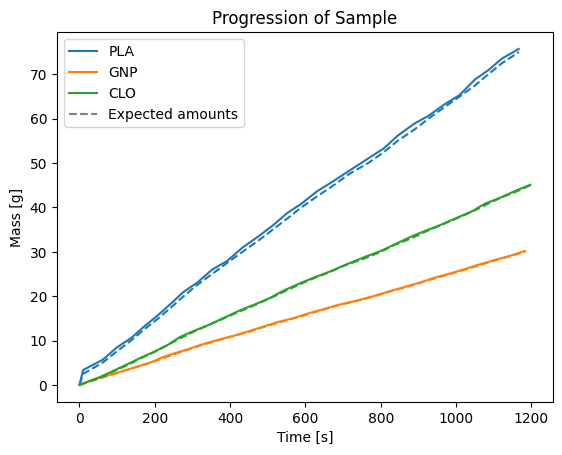

In [14]:
import matplotlib.pyplot as plt

colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"] 

for key in D.keys():
    plt.plot(times[D[key]-1], masses[D[key]-1],label=key, c=colors[D[key]-1])
    plt.plot(times[D[key]-1], np.arange(len(times[D[key]-1]))*ratios[D[key]-1], '--',c=colors[D[key]-1])
plt.plot(0,0,'--',c = 'gray',label = "Expected amounts")
plt.title("Progression of Sample")
plt.xlabel("Time [s]")
plt.ylabel("Mass [g]")
plt.legend()
plt.show()

Finally, we present a measure for accuracy consistent of the total error commited divided by the total amount dispensed:

In [15]:
final_masses = [mass[-1] for mass in masses[:]]
accuracy = (1-np.sum(abs(final_masses-C*mass_target))/np.sum(final_masses))*100
print("Accuracy: ", accuracy, "%")

Accuracy:  99.33511695054433 %


In [ ]:
times

In [ ]:
j

In [ ]:
i

In [ ]:
arduino.write(dispenser_switch['stop'])